# MLflow

[MLflow](https://mlflow.org/) is YALF (yet another logging framework) for data science experiments. You can log just about anything important from your experiments including stats, performances, parameters, figures, intermediary results, models, etc. Many different data science frameworks (or `flavors`) are supported, including [Scikit-Learn, PyTorch, XGBoost, etc](https://mlflow.org/docs/1.26.0/models.html#built-in-model-flavors). Since you can log the models (or persist the models), you can even use MLflow to depersist these models and make predictions! Let's see how MLflow works.

Here, we create a classification problem with the typical `Xy` data shapes.

In [1]:
from sklearn.datasets import make_classification
import pandas as pd

def get_Xy():
    n_features = 10
    X, y = make_classification(**{
        'n_samples': 2000,
        'n_features': n_features,
        'n_informative': 2,
        'n_redundant': 2,
        'n_repeated': 0,
        'n_classes': 2,
        'n_clusters_per_class': 1,
        'random_state': 37
    })
    
    cols = [f'x{i}' for i in range(n_features)]
    return pd.DataFrame(X, columns=cols), y

X, y = get_Xy()
X.shape, y.shape, X.columns

((2000, 10),
 (2000,),
 Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9'], dtype='object'))

Then, we split `Xy` into training `X_tr`, `y_tr` and testing `X_te`, `y_te`.

In [2]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=37)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((1400, 10), (1400,), (600, 10), (600,))

We are going to fit a logistic regression model and look at the performances for both training and testing sets.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, precision_score, recall_score, f1_score
import numpy as np

def get_model():
    estimator = LogisticRegression(**{
        'solver': 'saga',
        'penalty': 'l2',
        'random_state': 37,
        'max_iter': 1_000
    })

    cv = StratifiedKFold(**{
        'n_splits': 5,
        'shuffle': True,
        'random_state': 37
    })

    model = GridSearchCV(**{
        'estimator': estimator,
        'cv': cv,
        'param_grid': {
            'penalty': ['l1', 'l2'],
            'C': [0.01, 0.5, 0.7, 0.9]
        },
        'scoring': {
            'auc': 'roc_auc',
            'apr': 'average_precision'
        },
        'verbose': 5,
        'refit': 'apr',
        'error_score': np.NaN,
        'n_jobs': -1
    })
    
    return model

def get_performances(X_tr, y_tr, X_te, y_te, model):
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)
    
    pre_tr = precision_score(y_tr, y_tr_pred)
    pre_te = precision_score(y_te, y_te_pred)
    
    rec_tr = recall_score(y_tr, y_tr_pred)
    rec_te = recall_score(y_te, y_te_pred)
    
    f1_tr = f1_score(y_tr, y_tr_pred)
    f1_te = f1_score(y_te, y_te_pred)
    
    y_tr_prob = model.predict_proba(X_tr)[:,1]
    y_te_prob = model.predict_proba(X_te)[:,1]
    
    auc_tr = roc_auc_score(y_tr, y_tr_prob)
    auc_te = roc_auc_score(y_te, y_te_prob)
    
    aps_tr = average_precision_score(y_tr, y_tr_prob)
    aps_te = average_precision_score(y_te, y_te_prob)
    
    perf_metrics = {
        'pre_tr': pre_tr,
        'pre_te': pre_te,
        'rec_tr': rec_tr,
        'rec_te': rec_te,
        'f1_tr': f1_tr,
        'f1_te': f1_te,
        'auc_tr': auc_tr,
        'auc_te': auc_te,
        'aps_tr': aps_tr,
        'aps_te': aps_te
    }
    
    return perf_metrics

Here is where MLflow comes in. As we progress through our experimental procedure, we can log nearly anything we want about the experiment. The `tracking_uri` points to the MLflow server and the `experiment_name` is the name of your experiment (many models can map to the same experiment, such as a set of random forest, logistic regression and gradient boosting models). Below, we log

- the model,
- the performances of the model,
- the cross-validation results of the hyperparameter tuning grid search, and
- a few graphs to visualize the data.

Fitting 5 folds for each of 8 candidates, totalling 40 fits


2022/05/28 02:20:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpsy1b58yj/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==0.24.1', 'cloudpickle==1.6.0']. Set logging level to DEBUG to see the full traceback.


run_id=ae12b6f88a424d4783abb42b504f2bb7


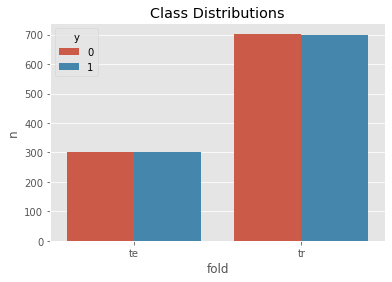

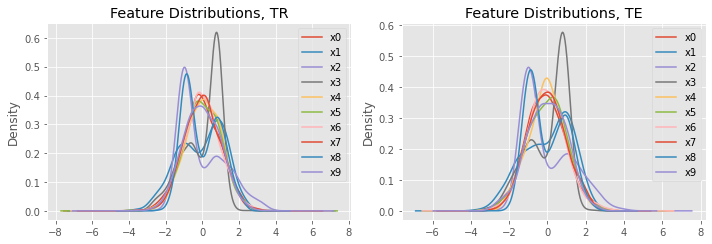

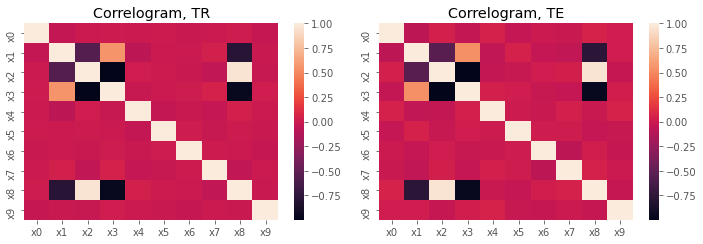

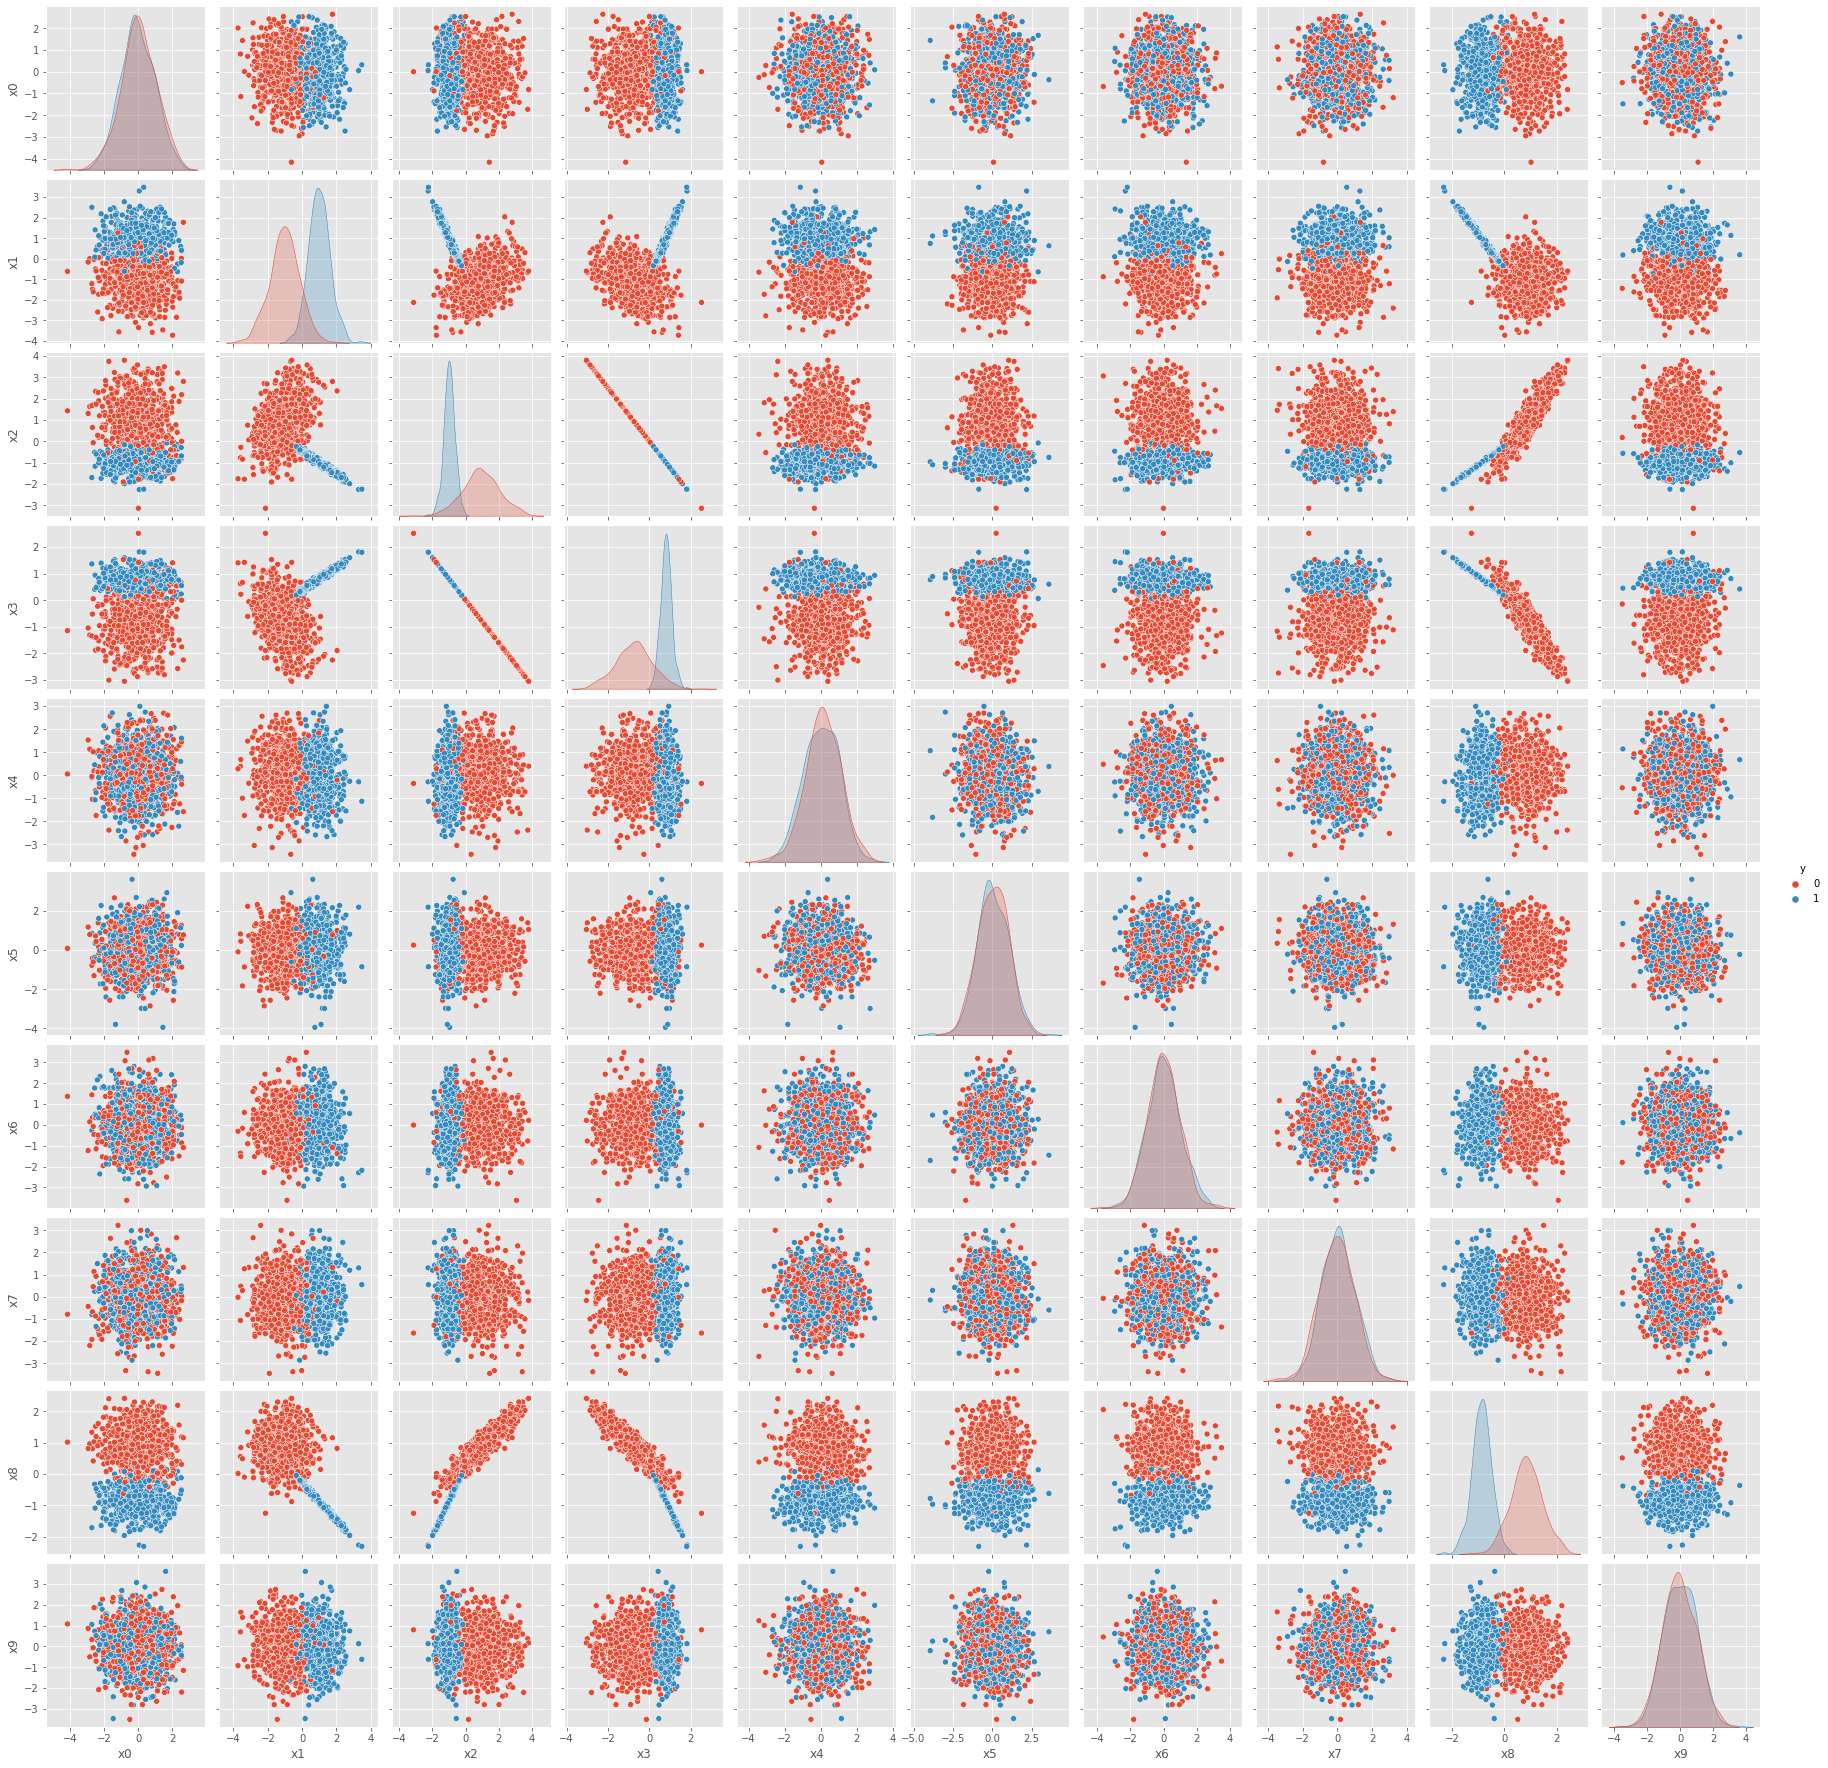

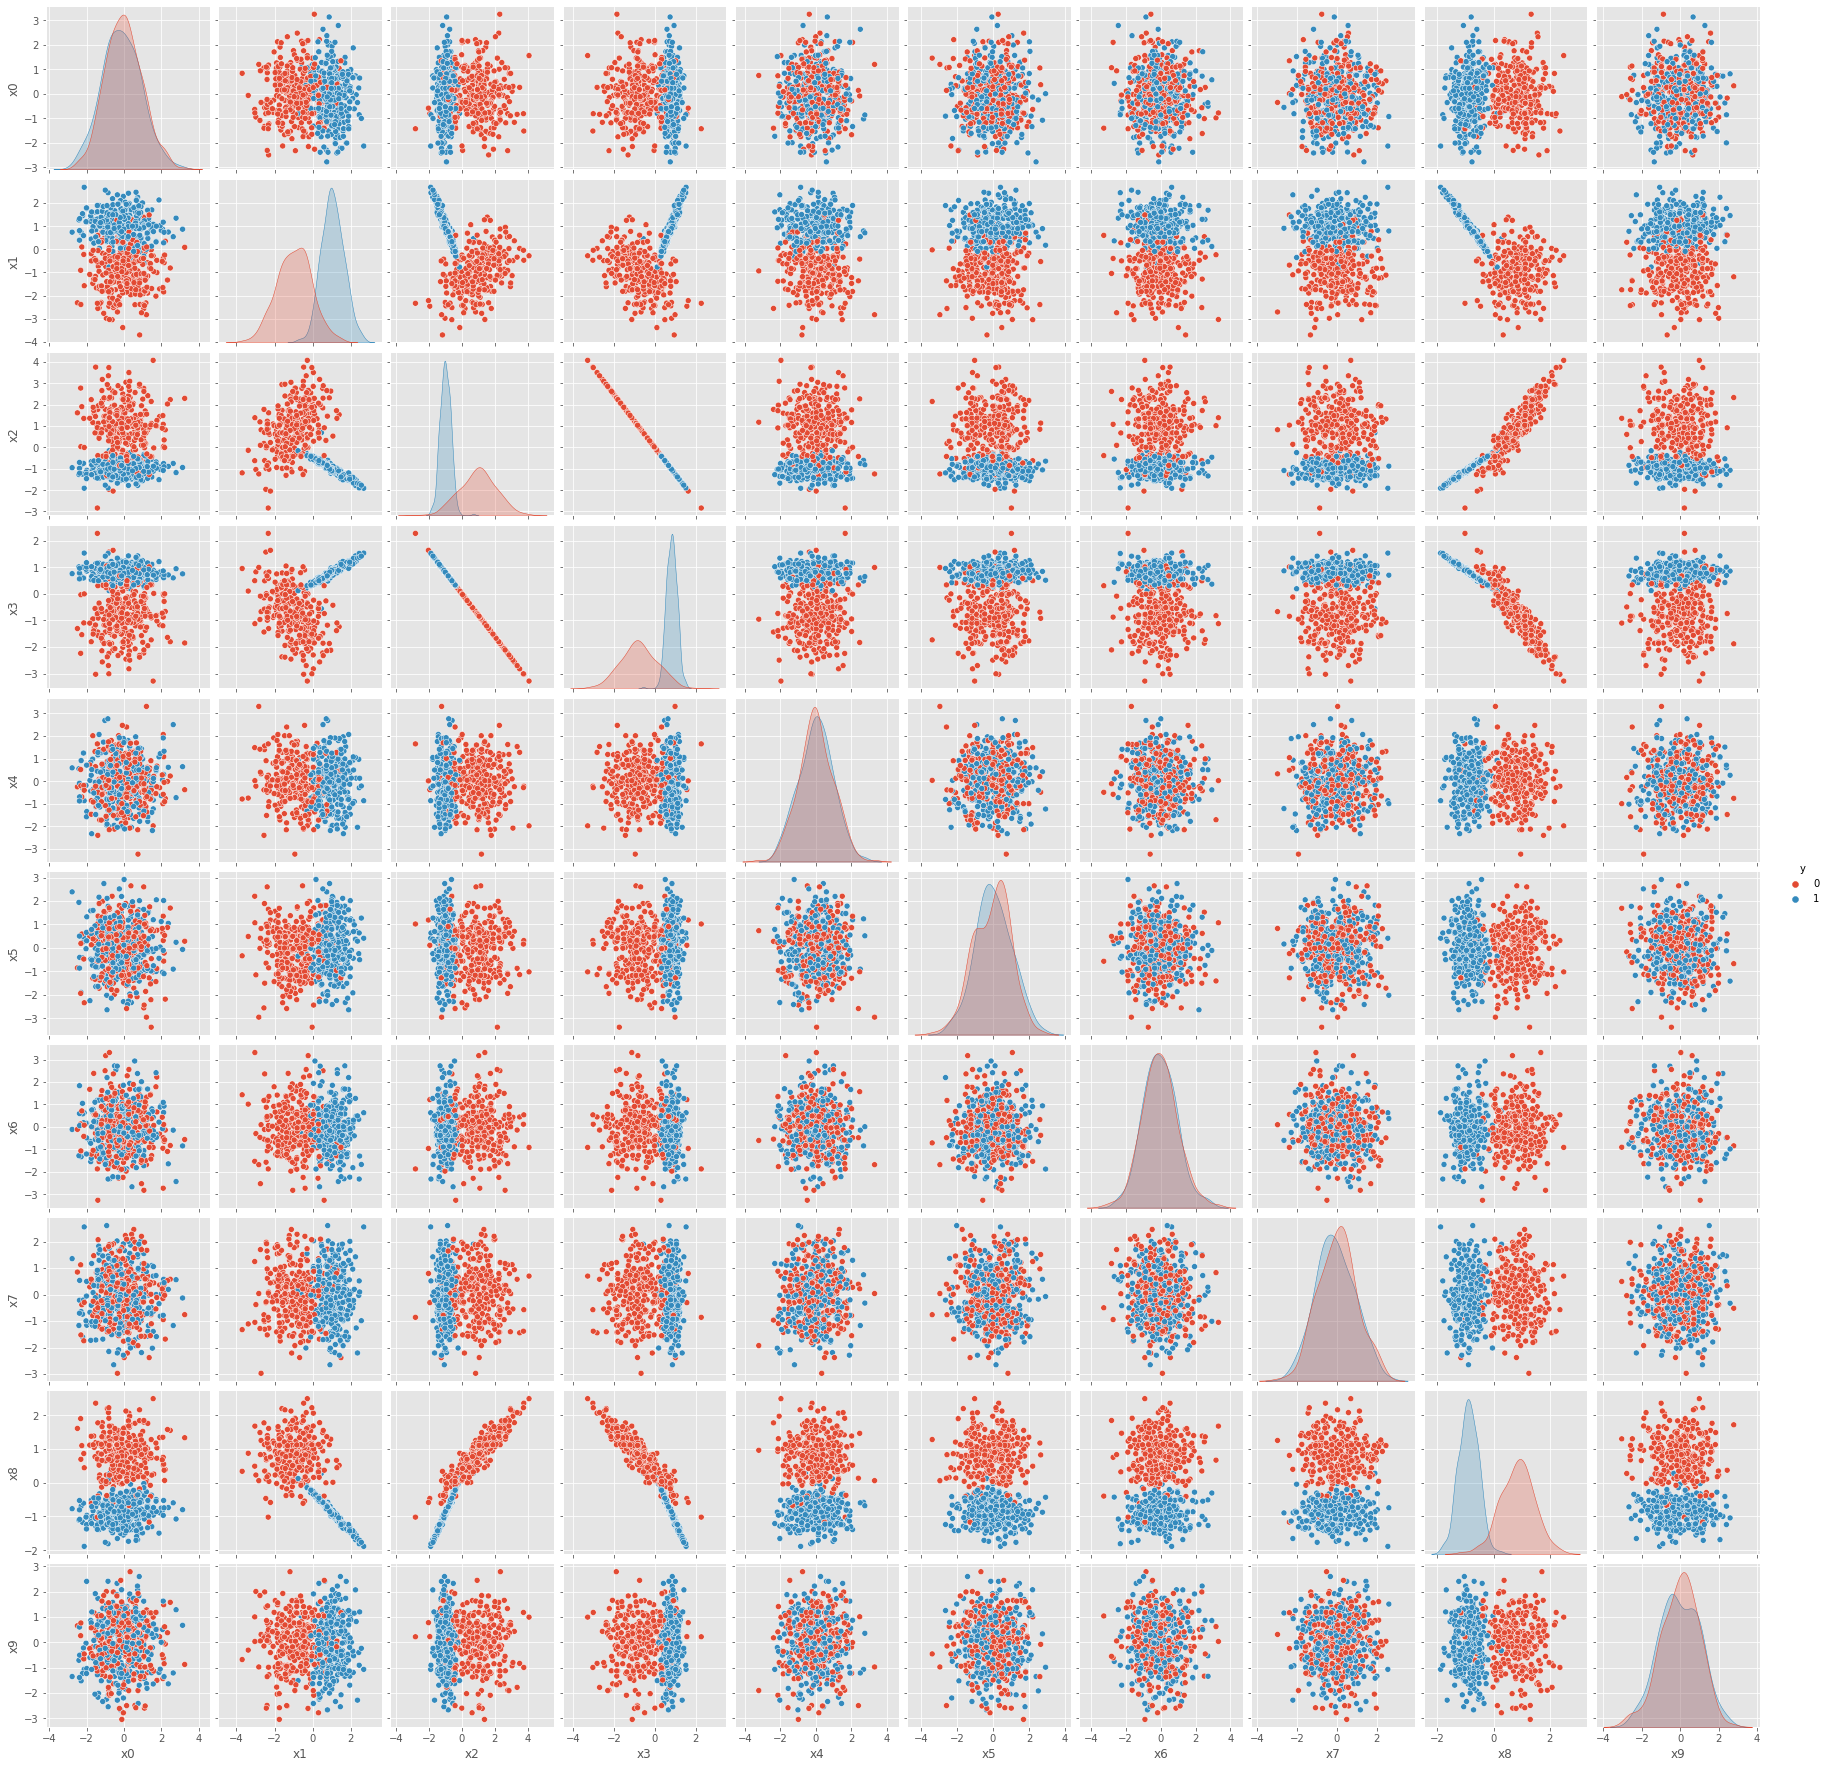

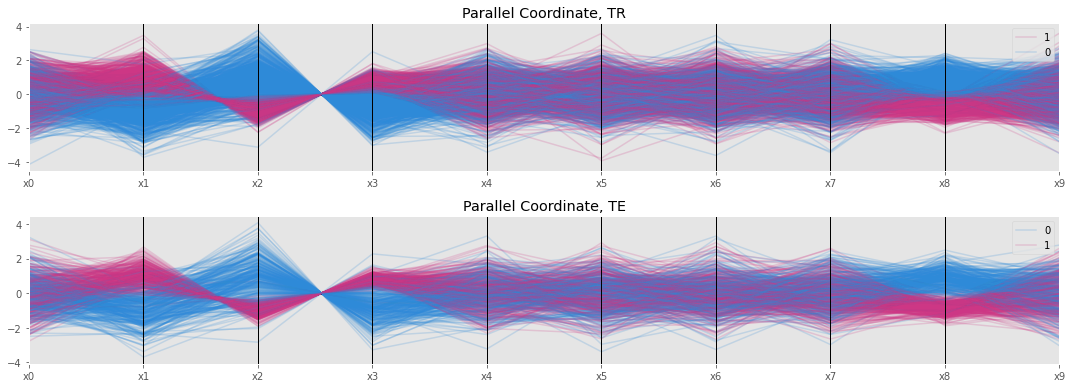

In [4]:
import mlflow
from mlflow.exceptions import MlflowException
from mlflow.models.signature import infer_signature
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

experiment_name = 'test1'

if not mlflow.get_experiment_by_name(experiment_name):
    try:
        mlflow.create_experiment(experiment_name)
    except MlflowException as ex:
        print(f'{ex}')
        
tracking_uri = 'http://localhost:5001'

mlflow.set_tracking_uri(tracking_uri)
mlflow.set_experiment(experiment_name)

with mlflow.start_run() as run:
    model = get_model()
    model.fit(X_tr, y_tr)
    
    signature = infer_signature(X_tr, model.predict_proba(X_tr))
    mlflow.sklearn.log_model(model, 'model', signature=signature)
    mlflow.log_params(model.best_params_)
    
    perf_metrics = get_performances(X_tr, y_tr, X_te, y_te, model)
    mlflow.log_metrics(perf_metrics)
    
    pd.DataFrame({k: model.cv_results_[k] for k in model.cv_results_ if k not in {'params'}}) \
        .to_csv('./_temp/cv-results.csv', index=False)
    mlflow.log_artifact('./_temp/cv-results.csv', 'artifact')
    
    temp = pd.concat([
        pd.DataFrame({'y': y_tr}).assign(fold='tr'),
        pd.DataFrame({'y': y_te}).assign(fold='te')
    ]).assign(n=1).groupby(['fold', 'y'])['n'].sum().to_frame().reset_index()
    fig, ax = plt.subplots()
    sns.barplot(x='fold', hue='y', y='n', data=temp, ax=ax)
    ax.set_title('Class Distributions')
    mlflow.log_figure(fig, 'fig/00-class-distributions.png')
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
    X_tr.plot(kind='kde', ax=ax[0], title='Feature Distributions, TR')
    X_te.plot(kind='kde', ax=ax[1], title='Feature Distributions, TE')
    plt.tight_layout()
    mlflow.log_figure(fig, 'fig/01-feature-distributions.png')
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
    sns.heatmap(X_tr.corr(), ax=ax[0])
    sns.heatmap(X_te.corr(), ax=ax[1])
    ax[0].set_title('Correlogram, TR')
    ax[1].set_title('Correlogram, TE')
    plt.tight_layout()
    mlflow.log_figure(fig, 'fig/02-correlograms.png')
    
    fig = sns.pairplot(X_tr.assign(y=y_tr), hue='y').fig
    mlflow.log_figure(fig, 'fig/03-00-tr-pairplot.png')
    
    fig = sns.pairplot(X_te.assign(y=y_te), hue='y').fig
    mlflow.log_figure(fig, 'fig/03-01-te-pairplot.png')
    
    fig, ax = plt.subplots(2, 1, figsize=(15, 5.5))
    pd.plotting.parallel_coordinates(X_tr.assign(y=y_tr), 'y', X_tr.columns, color=['#2e8ad8', '#cd3785'], sort_labels=True, axvlines=True, alpha=0.2, ax=ax[0])
    pd.plotting.parallel_coordinates(X_te.assign(y=y_te), 'y', X_tr.columns, color=['#2e8ad8', '#cd3785'], sort_labels=True, axvlines=True, alpha=0.2, ax=ax[1])
    ax[0].set_title('Parallel Coordinate, TR')
    ax[1].set_title('Parallel Coordinate, TE')
    plt.tight_layout()
    mlflow.log_figure(fig, 'fig/04-parallel-coordinate.png')
    
    run_id = mlflow.active_run().info.run_id
    print(f'run_id={run_id}')

Finally, we can load the model (using the `run_id`) and make predictions. Note how we persisted/logged the model using the `sklearn` flavor and also depersisted/loaded the model using the `sklearn` flavor again.

In [6]:
loaded_model = mlflow.sklearn.load_model(f'runs:/{run_id}/model')
loaded_model.predict_proba(X_tr)

array([[0.62361146, 0.37638854],
       [0.93569093, 0.06430907],
       [0.16239568, 0.83760432],
       ...,
       [0.0796527 , 0.9203473 ],
       [0.90753055, 0.09246945],
       [0.0532899 , 0.9467101 ]])